<a href="https://colab.research.google.com/github/Kartik-007/BankStatement/blob/main/BankStatementProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tabula-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 23.8 MB/s eta 0:00:00


In [2]:
import tabula
import pandas as pd
tabula.environment_info()

Python version:
    3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Java version:
    openjdk version "11.0.20.1" 2023-08-24
OpenJDK Runtime Environment (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.20.1+1-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
tabula-py version: 2.8.2
platform: Linux-5.15.120+-x86_64-with-glibc2.35
uname:
    uname_result(system='Linux', node='5007ed543317', release='5.15.120+', version='#1 SMP Wed Aug 30 11:19:59 UTC 2023', machine='x86_64')
linux_distribution: ('Ubuntu', '22.04', 'jammy')
mac_ver: ('', ('', '', ''), '')


In [3]:
import tabula
import pandas as pd
from google.colab import files

class StatementReader:
    def __init__(self, pdf_path, bank_company):
        """
        Initialize the StatementReader object.

        Parameters:
        - pdf_path (str): The path to the PDF file.
        - bank_company (str): The name of the bank company for which the statement is being processed.
        """
        self.pdf_path = pdf_path
        self.dfs = None
        self.df_total = None
        self.bank_company = bank_company
        self.column_mappings = {
            'Kotak': {
                0: 'Date',
                1: 'Transaction Details',
                2: 'Reference Number',
                3: 'Debit',
                4: 'Credit',
                5: 'Opening Balance'
            },
            'HDFC': {
                0: 'Date',
                1: 'Transaction Details',
                2: 'Reference Number',
                4: 'Debit',
                5: 'Credit',
                6: 'Opening Balance'
            },
            'ICICI': {
                0: 'Date',
                2: 'Transaction Details',
                4: 'Reference Number',
                5: 'Debit',
                6: 'Credit',
                7: 'Opening Balance'
            },
            'IDBI': {
                1: 'Date',
                3: 'Transaction Details',
                4: 'Reference Number',
                5: 'Debit',
                6: 'Credit',
                7: 'Opening Balance'
            },
            # Add mappings for other banks as needed
        }

    def read_pdf(self):
        self.dfs = tabula.read_pdf(self.pdf_path, stream=True, pages="all")

    def display_dataframes(self):
        """
        Display each DataFrame in the list (self.dfs).

        Dynamically creates DataFrame attributes (df_1, df_2, etc.) for each DataFrame.
        """
        for idx, df in enumerate(self.dfs):
            df.columns = range(df.shape[1])
            df_name = f'df_{idx + 1}'
            setattr(self, df_name, pd.DataFrame(df))

    def concat_dataframes(self):
        """
        Concatenate individual DataFrames into a single DataFrame (self.df_total).

        Display the concatenated DataFrame.
        """
        dfs_list = [getattr(self, f'df_{idx + 1}') for idx in range(len(self.dfs))]
        self.df_total = pd.concat(dfs_list, ignore_index=True)

    def rename_columns(self):
        """
        Rename columns of the combined DataFrame (self.df_total) based on the bank company's column mapping.

        Select the appropriate column mapping based on self.bank_company.
        """
        if self.df_total is not None:
            selected_mapping = self.column_mappings.get(self.bank_company, {})
            self.df_total.rename(columns=selected_mapping, inplace=True)

    def preprocess(self):
        """
        Perform data preprocessing on the combined DataFrame (self.df_total).

        Steps:
        1. Convert 'Date' to datetime format.
        2. Convert 'Debit' and 'Credit' to numeric format.
        3. Drop unnecessary columns.
        4. Drop rows with missing 'Date'.
        5. Fill missing values in 'Credit' and 'Debit' with zeros.
        """
        # 1. Convert 'Date' to datetime format
        formats = ['%d %b, %Y', '%d/%m/%y']
        date_format = None

        for fmt in formats:
            try:
                self.df_total['Date'] = pd.to_datetime(self.df_total['Date'], format=fmt)
                date_format = fmt
                break
            except ValueError:
                continue

        if date_format is None:
            print("Warning: Date format not recognized. Please check your data.")

        # date_formats = ['%d %b, %Y', '%d/%m/%y']
        # self.df_total['Date'] = pd.to_datetime(self.df_total['Date'], format=date_formats, errors='coerce')
        # self.df_total['Date'] = pd.to_datetime(self.df_total['Date'], format='%d %b, %Y')

        # 2. Convert 'Debit' and 'Credit' to numeric format
        self.clean_and_convert_column('Debit')
        self.clean_and_convert_column('Credit')

        # 3. Drop unnecessary columns
        self.df_total.drop(columns=['Opening Balance', 'Reference Number'], inplace=True)

        # 4. Drop rows with missing 'Date'
        self.df_total.dropna(subset=['Date'], inplace=True)

        # 5. Fill missing values in 'Credit' and 'Debit' with zeros
        self.df_total['Credit'].fillna(0, inplace=True)
        self.df_total['Debit'].fillna(0, inplace=True)

    def clean_and_convert_column(self, column_name):
        # Clean the specified column using regular expressions
        self.df_total[column_name] = self.df_total[column_name].str.replace(',', '', regex=True)
        self.df_total[column_name] = self.df_total[column_name].str.extract('(\d+\.\d+|\d+)')
        self.df_total[column_name] = self.df_total[column_name].astype(float)


    def process_statement(self):
        """
        Process the bank statement: read PDF, display DataFrames, concatenate, and rename columns.

        Returns:
        - pd.DataFrame: The final combined DataFrame (self.df_total).
        """
        self.read_pdf()
        self.display_dataframes()
        self.concat_dataframes()
        self.rename_columns()
        self.preprocess()
        return self.df_total




In [4]:
# pdf_path = "/content/50100345522390_1698412630302.pdf"
# bank_company = "HDFC"  # Replace with the actual bank company name

pdf_path = "/content/sampleBankStatement.pdf"
bank_company = "Kotak"  # Replace with the actual bank company name

reader = StatementReader(pdf_path, bank_company)
df_total = reader.process_statement()

# Print the combined DataFrame
display(df_total)

,Date,Transaction Details,Debit,Credit
0,2023-08-02,UPI/FINESSE/321480029436/UPI,7625.00,0.0
1,2023-08-03,PCD/8386/GOOGLE WORKSPACE CYBS/SI,1585.92,0.0
3,2023-08-04,UPI/RUPALI SHREEYAS/321637814160/UPI,750.00,0.0
4,2023-08-04,UPI/Blinkit/321655141619/Blinkit Payment,348.00,0.0
5,2023-08-04,UPI/Blinkit/321655281777/UPI Transaction,224.00,0.0
6,2023-08-05,UPI/Blinkit/321777156790/UPI Transaction,369.00,0.0
7,2023-08-07,UPI/Apple Services/321925854705/MandateRequest,129.00,0.0
8,2023-08-07,UPI/MOHD ALAM MOHMM/321930617907/UPI,129.00,0.0
9,2023-08-08,UPI/Airtel Payments/322058872359/UPI Transaction,3655.64,0.0
10,2023-08-08,UPI/Razorpay Softwa/322064032102/Paymenttocabeca,650.00,0.0


# New Section

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import difflib
from wordcloud import WordCloud

class Analyzer:
    def __init__(self, combined_df):
        self.combined_df = combined_df

    def analyze_expense_categories_over_time(self):
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=self.combined_df, x='Date', y='Debit', ci=None)
        plt.title('Debit Over Time')
        plt.xlabel('Date')
        plt.ylabel('Debit Amount ($)')
        plt.show()

    def transaction_frequency_over_time(self):
        plt.figure(figsize=(12, 6))
        transaction_count = self.combined_df['Date'].value_counts().sort_index()
        transaction_count.plot(kind='line', marker='o')
        plt.title('Transaction Frequency Over Time')
        plt.xlabel('Date')
        plt.ylabel('Number of Transactions')
        plt.show()

    def analyze_income_vs_expenses(self):
        # Group by 'Date' and sum the 'Credit' and 'Debit' amounts
        grouped_data = self.combined_df.groupby('Date')[['Credit', 'Debit']].sum().reset_index()

        plt.figure(figsize=(12, 6))
        ax = sns.barplot(data=grouped_data, x='Date', y='Credit', color='blue', label='Credit')
        ax = sns.barplot(data=grouped_data, x='Date', y='Debit', color='orange', label='Debit')

        # Customize the date formatting for x-axis ticks
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
        ax.set_xticks(range(len(grouped_data)))

        plt.title('Income vs. Expenses Over Time')
        plt.xlabel('Date')
        plt.ylabel('Amount ($)')
        plt.legend()
        plt.show()

    def analyze_cash_flow(self):
        cash_flow_df = self.combined_df[['Date', 'Credit', 'Debit']].copy()
        cash_flow_df['Cash Flow'] = cash_flow_df['Credit'] - cash_flow_df['Debit']

        plt.figure(figsize=(12, 6))
        sns.lineplot(data=cash_flow_df, x='Date', y='Cash Flow', ci=None)
        plt.title('Cash Flow Over Time')
        plt.xlabel('Date')
        plt.ylabel('Cash Flow Amount ($)')
        plt.show()

    def group_and_plot_similar_transactions(self):
        # Define a function to identify similar transactions
        def get_grouped_transactions(transaction_details):
            transactions = []
            groups = []
            for transaction in transaction_details:
                found = False
                for group in groups:
                    for t in group:
                        if difflib.SequenceMatcher(None, transaction, t).ratio() > 0.55:
                            group.append(transaction)
                            found = True
                            break
                if not found:
                    groups.append([transaction])
            return groups

        # Group similar transactions based on pattern recognition
        transaction_groups = get_grouped_transactions(self.combined_df['Transaction Details'])

        # Calculate the net credit and debit for each group
        group_totals = []
        for group in transaction_groups:
            group_df = self.combined_df[self.combined_df['Transaction Details'].isin(group)]
            net_credit = group_df['Credit'].sum()
            net_debit = group_df['Debit'].sum()
            group_totals.append((group[0], net_credit - net_debit))

        # Create a DataFrame for the grouped expenses
        grouped_expenses_df = pd.DataFrame(group_totals, columns=['Transaction Details', 'Net Amount'])

        plt.figure(figsize=(12, 6))
        sns.barplot(data=grouped_expenses_df, x='Net Amount', y='Transaction Details', palette='viridis')
        plt.title('Grouped Expenses (Net Credit/Debit)')
        plt.xlabel('Net Amount ($)')
        plt.ylabel('Transaction Details')
        plt.show()

    def heatmap_transactions_by_day_hour(self):
        grouped_data = self.combined_df.groupby([self.combined_df['Date'].dt.day_name(), self.combined_df['Date'].dt.hour])['Transaction Details'].count().unstack()
        plt.figure(figsize=(12, 8))
        sns.heatmap(grouped_data, cmap='viridis')
        plt.title('Transactions by Day and Hour')
        plt.xlabel('Hour of the Day')
        plt.ylabel('Day of the Week')
        plt.show()

    def correlation_matrix(self):
        plt.figure(figsize=(8, 6))
        correlation_matrix = self.combined_df[['Debit', 'Credit']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()

    def analyze_transaction_details(self):
        plt.figure(figsize=(10, 8))
        expense_categories = self.combined_df.groupby('Transaction Details')['Debit'].sum().sort_values(ascending=False)
        expense_categories.plot(kind='bar', color='teal')
        plt.title('Transaction Details - Expense Categories')
        plt.xlabel('Expense Categories')
        plt.ylabel('Total Debit Amount ($)')
        plt.xticks(rotation=45, ha='right')
        plt.show()

    def analyze_credit_vs_debit_trends(self):
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=self.combined_df, x='Date', y='Credit', label='Credit')
        sns.lineplot(data=self.combined_df, x='Date', y='Debit', label='Debit')
        plt.title('Credit vs. Debit Trends Over Time')
        plt.xlabel('Date')
        plt.ylabel('Amount ($)')
        plt.legend()
        plt.show()

    def analyze_balance_over_time(self):
        plt.figure(figsize=(12, 6))
        sns.lineplot(data=self.combined_df, x='Date', y='Opening Balance')
        plt.title('Balance Over Time')
        plt.xlabel('Date')
        plt.ylabel('Balance Amount ($)')
        plt.show()

    def word_cloud_transaction_details(self):
        plt.figure(figsize=(10, 6))
        text = ' '.join(self.combined_df['Transaction Details'].astype(str).values)
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title('Word Cloud of Transaction Details')
        plt.show()

    def categorize_transactions(self):
        """
        Categorize transactions based on their type (e.g., IMPS, ACH C, NEFT, POS, UPI).

        This method creates a new column 'Transaction Type' in the DataFrame.
        """
        transaction_types = ["IMPS", "ACH C", "NEFT", "POS", "UPI"]

        # Use the 'Transaction Details' column to categorize transactions
        self.combined_df['Transaction Type'] = self.combined_df['Transaction Details'].apply(
            lambda x: next((t for t in transaction_types if x.startswith(t)), 'Other')
        )

    def plot_transaction_type_percentage(self):
        """
        Plot a pie chart showing the percentage of different transaction types.

        This method uses the 'Transaction Type' column.
        """
        plt.figure(figsize=(8, 8))
        type_counts = self.combined_df['Transaction Type'].value_counts()
        plt.pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', startangle=140)
        plt.title('Percentage of Different Transaction Types')
        plt.legend(type_counts.index, loc="best")
        plt.show()

    def plot_average_transaction_amount(self, transaction_type, credit=True):
        """
        Plot a bar chart showing the average transaction amount for a specific type (credit or debit).

        Parameters:
        - transaction_type (str): The transaction type to filter.
        - credit (bool): If True, plot credit amounts; if False, plot debit amounts.
        """
        plt.figure(figsize=(10, 6))
        title = f'Average {transaction_type} Amount (Credit)' if credit else f'Average {transaction_type} Amount (Debit)'
        y_label = 'Credit Amount ($)' if credit else 'Debit Amount ($)'

        if credit:
            data = self.combined_df[self.combined_df['Transaction Type'] == transaction_type]['Credit']
        else:
            data = self.combined_df[self.combined_df['Transaction Type'] == transaction_type]['Debit']

        sns.barplot(x='Transaction Type', y=data, data=self.combined_df)
        plt.title(title)
        plt.xlabel('Transaction Type')
        plt.ylabel(y_label)
        plt.show()




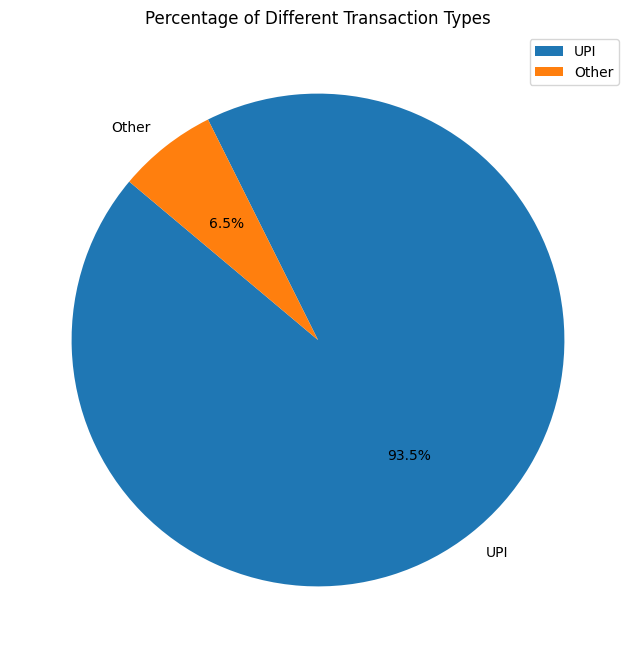

<ipython-input-16-c0bb015594fb>:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=self.combined_df, x='Date', y='Debit', ci=None)


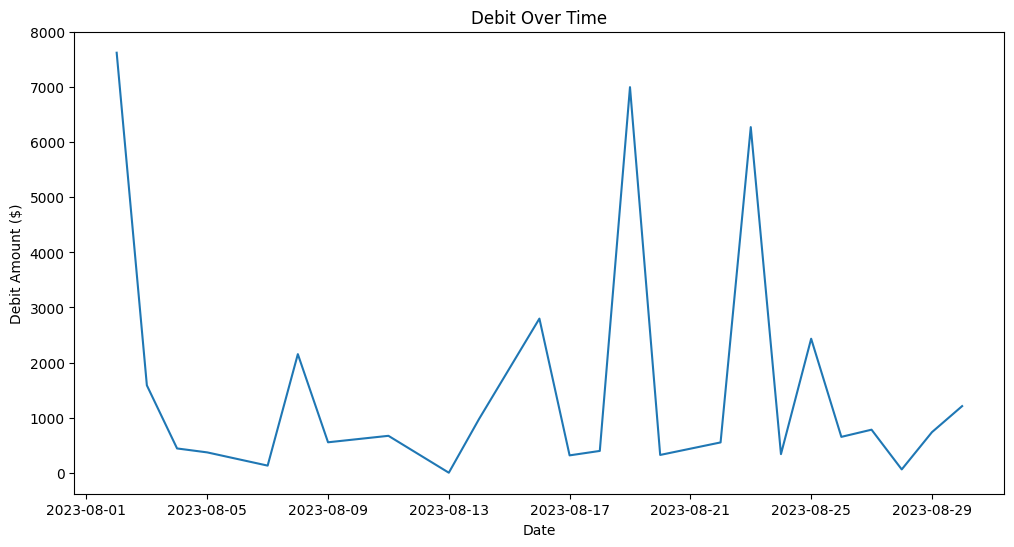

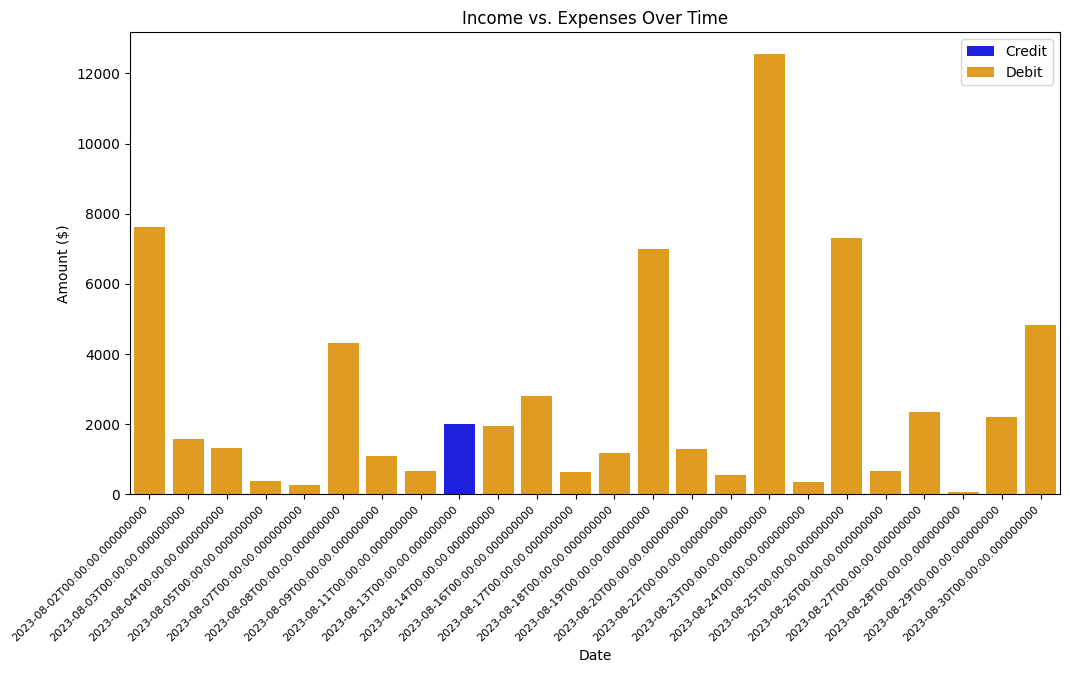

<ipython-input-16-c0bb015594fb>:51: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=cash_flow_df, x='Date', y='Cash Flow', ci=None)


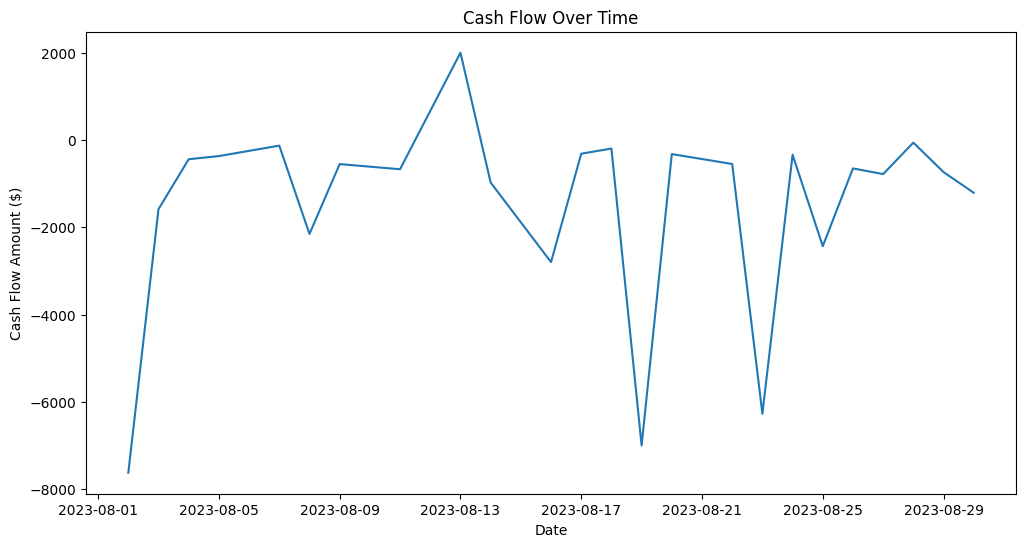

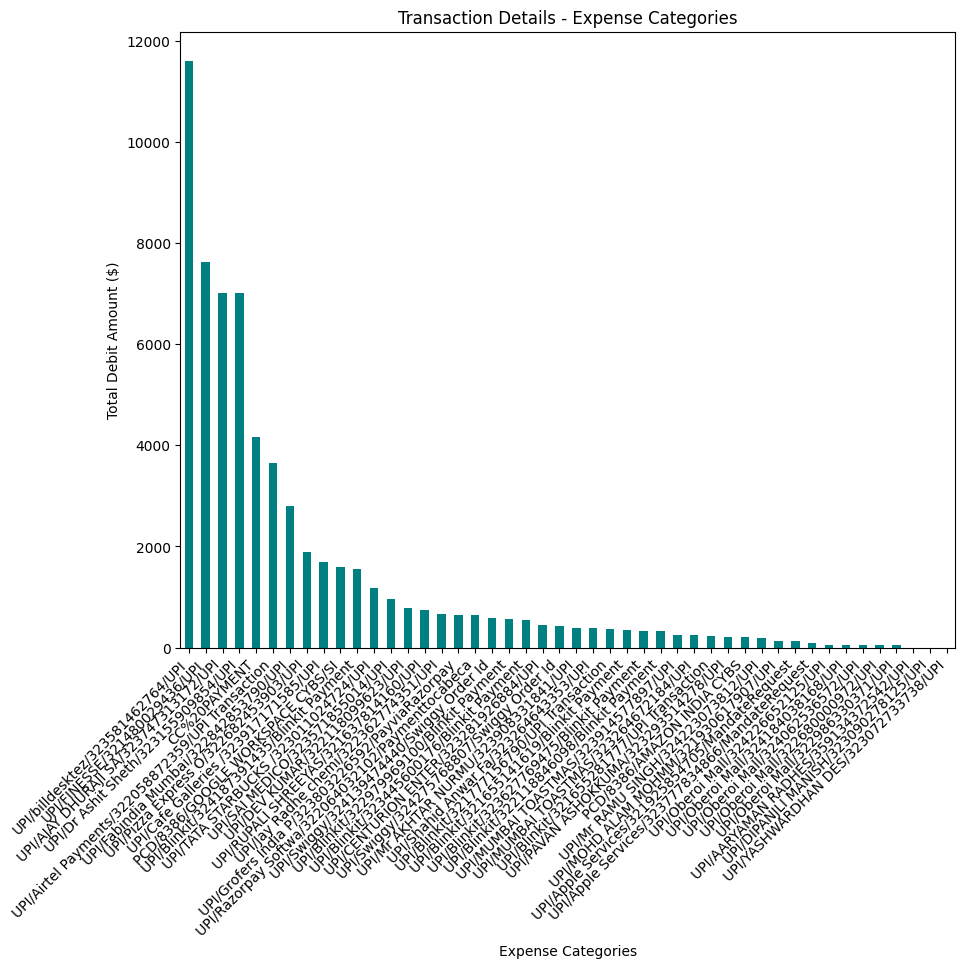

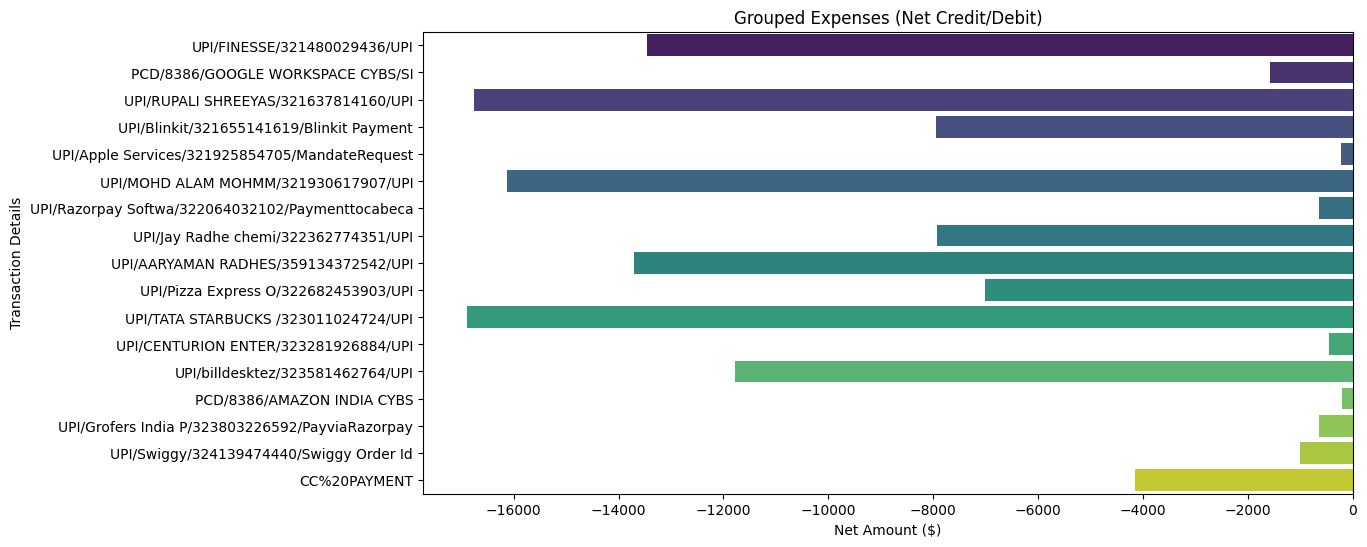

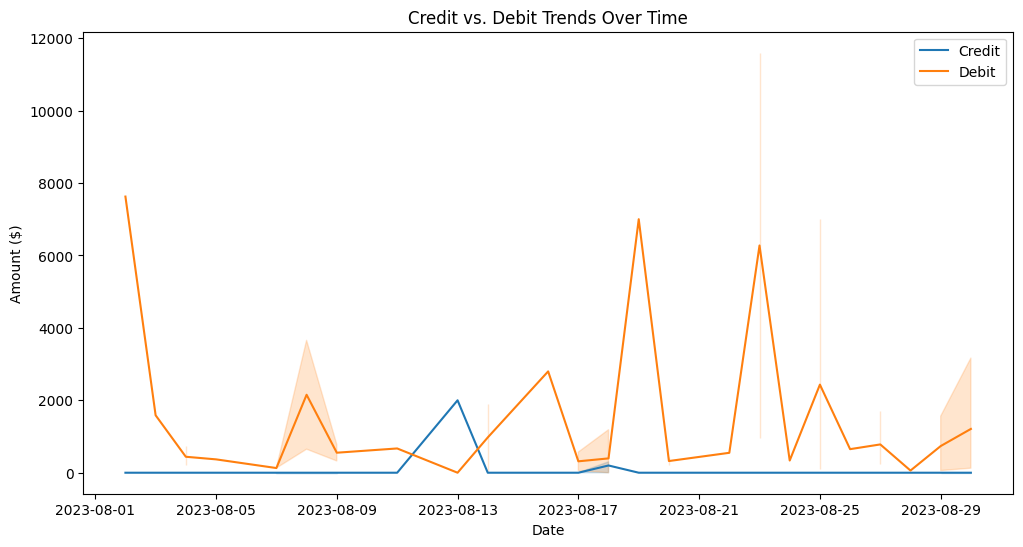

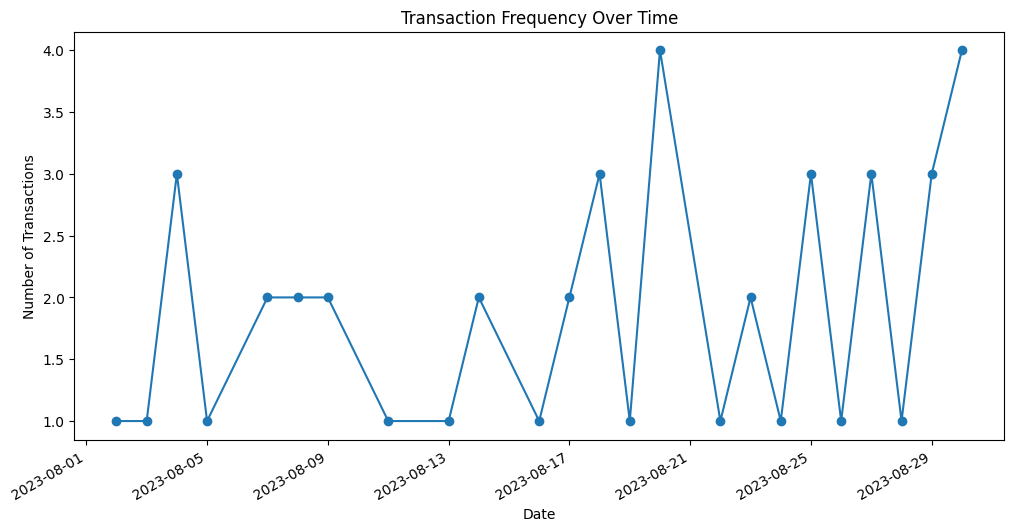

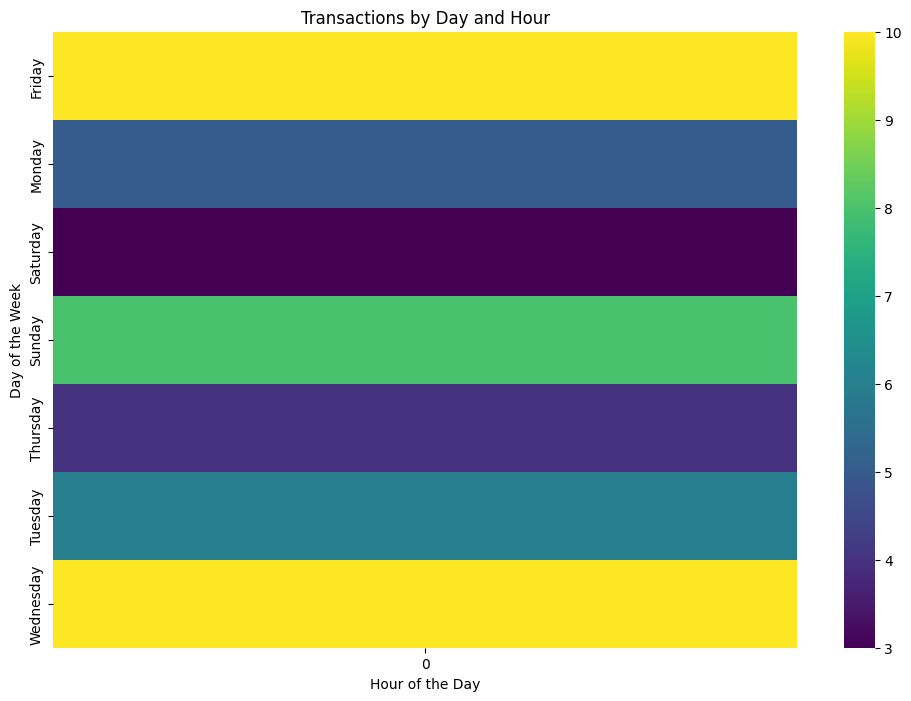

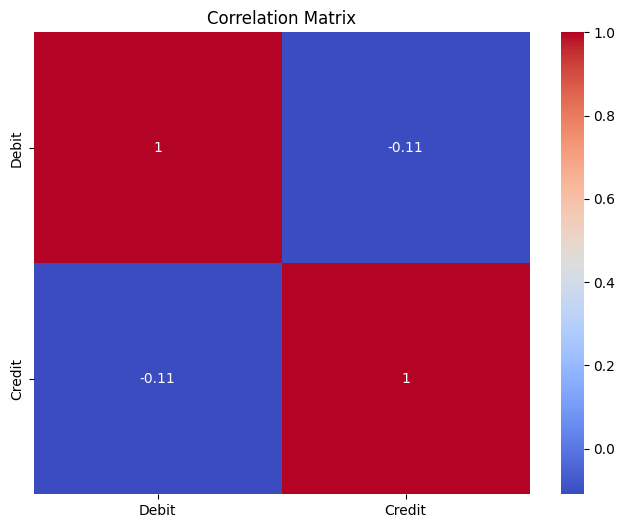

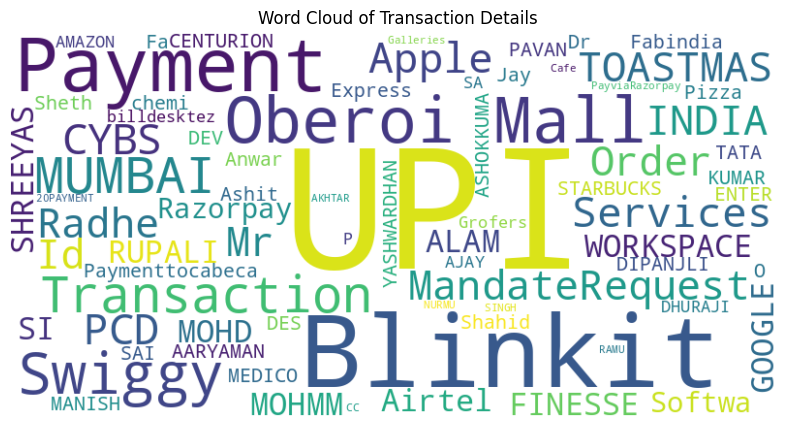

In [17]:
# Example usage:
# Assuming you already have the combined_df from the StatementReader class
analyzer = Analyzer(df_total)



# Categorize transactions based on their type
analyzer.categorize_transactions()

# Plot the percentage of different transaction types
analyzer.plot_transaction_type_percentage()

# Plot the average transaction amounts for specific types (e.g., "IMPS")
# analyzer.plot_average_transaction_amount('IMPS', credit=True)
# analyzer.plot_average_transaction_amount('IMPS', credit=False)

# # Analyze and plot the charts
analyzer.analyze_expense_categories_over_time()
analyzer.analyze_income_vs_expenses()
analyzer.analyze_cash_flow()
analyzer.analyze_transaction_details()
analyzer.group_and_plot_similar_transactions()
analyzer.analyze_credit_vs_debit_trends()
analyzer.transaction_frequency_over_time()
analyzer.heatmap_transactions_by_day_hour()
analyzer.correlation_matrix()
analyzer.word_cloud_transaction_details()
analyzer

In [ ]:
df_total["Day of the week"] = df_total["Date"].dt.day_name()
print(df_total.head())

        Date                       Transaction Details    Debit  Credit  \
1 2023-08-02              UPI/FINESSE/321480029436/UPI  7625.00     0.0   
2 2023-08-03         PCD/8386/GOOGLE WORKSPACE CYBS/SI  1585.92     0.0   
4 2023-08-04      UPI/RUPALI SHREEYAS/321637814160/UPI   750.00     0.0   
5 2023-08-04  UPI/Blinkit/321655141619/Blinkit Payment   348.00     0.0   
6 2023-08-04  UPI/Blinkit/321655281777/UPI Transaction   224.00     0.0   

  Day of the week  
1       Wednesday  
2        Thursday  
4          Friday  
5          Friday  
6          Friday  


In [ ]:
df_total.index = df_total.index + 1
print(df_total.head())

        Date                       Transaction Details    Debit  Credit
1 2023-08-02              UPI/FINESSE/321480029436/UPI  7625.00     0.0
2 2023-08-03         PCD/8386/GOOGLE WORKSPACE CYBS/SI  1585.92     0.0
4 2023-08-04      UPI/RUPALI SHREEYAS/321637814160/UPI   750.00     0.0
5 2023-08-04  UPI/Blinkit/321655141619/Blinkit Payment   348.00     0.0
6 2023-08-04  UPI/Blinkit/321655281777/UPI Transaction   224.00     0.0


In [ ]:
df_total.info()

In [ ]:
#Data analysis
import matplotlib.pyplot as plt
import seaborn as sns

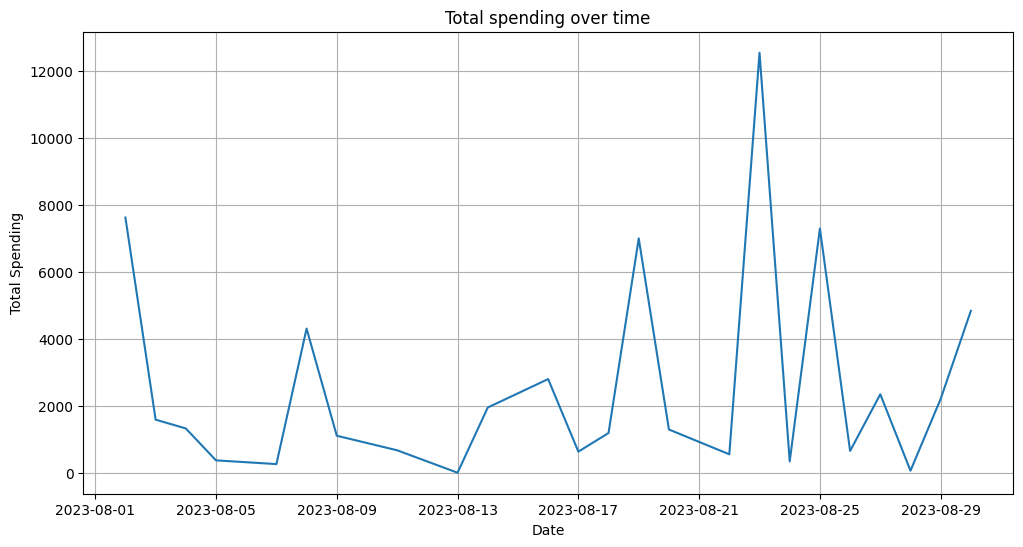

In [ ]:
#Spending over time
date_wise_spending = df_total.groupby('Date')['Debit'].sum()

#line plot
plt.figure(figsize=(12,6))
plt.plot(date_wise_spending.index, date_wise_spending.values, linestyle='-')
plt.title('Total spending over time')
plt.xlabel('Date')
plt.ylabel('Total Spending')
plt.grid()
plt.show()

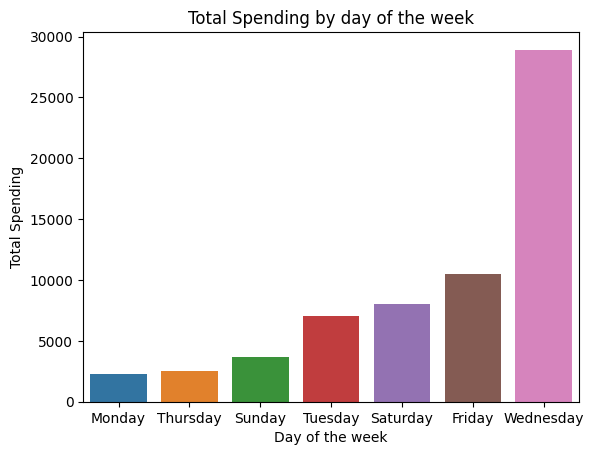

In [ ]:
#Day of the week spending
df_total['Debit'] = df_total['Debit'].abs()
day_of_week_spending = df_total.groupby('Day of the week')['Debit'].sum().sort_values()
sns.barplot(x=day_of_week_spending.index,y=day_of_week_spending.values)
plt.title("Total Spending by day of the week")
plt.xlabel('Day of the week')
plt.ylabel('Total Spending')
plt.show()


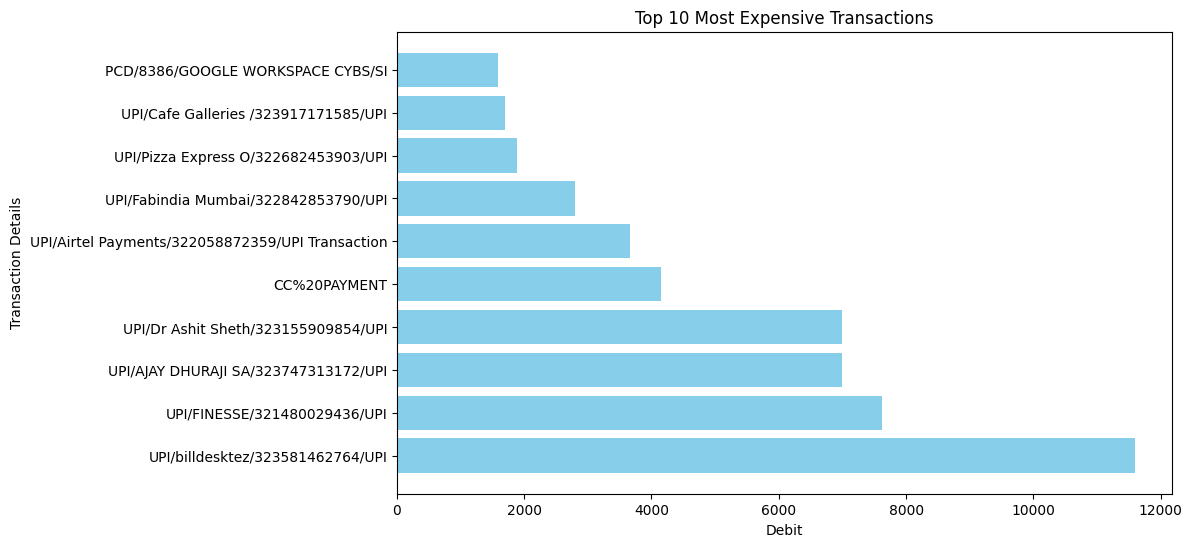

Most Expensive Transaction Details:
Date                                2023-08-23 00:00:00
Transaction Details    UPI/billdesktez/323581462764/UPI
Debit                                           11597.0
Credit                                              0.0
Day of the week                               Wednesday
Name: 31, dtype: object


In [ ]:
sorted_df = df_total.sort_values(by='Debit', ascending=False)

top = 10
top_transactions = sorted_df.head(top)

plt.figure(figsize=(10,6))
plt.barh(top_transactions['Transaction Details'], top_transactions['Debit'], color='skyblue')
plt.title('Top {} Most Expensive Transactions'.format(top))
plt.xlabel('Debit')
plt.ylabel('Transaction Details')
plt.show()

most_expensive_transaction = sorted_df.iloc[0]

print("Most Expensive Transaction Details:")
print(most_expensive_transaction)